In [1]:
print(("Let's get this money!!"))


Let's get this money!!


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/HW5_train_val.zip /content
!unzip HW5_train_val.zip


Mounted at /content/gdrive
Archive:  HW5_train_val.zip
 extracting: DIV2K_train_HR.zip      
 extracting: DIV2K_train_LR_bicubic_X4.zip  
 extracting: DIV2K_valid_HR.zip      
 extracting: DIV2K_valid_LR_bicubic_X4.zip  


In [3]:
!mkdir /content/valid_HR
!mkdir /content/train_HR

!mv DIV2K_train_HR.zip /content/train_HR  
!mv DIV2K_valid_HR.zip /content/valid_HR

!unzip /content/train_HR/DIV2K_train_HR.zip
!unzip /content/DIV2K_train_LR_bicubic_X4.zip
!unzip /content/valid_HR/DIV2K_valid_HR.zip
!unzip /content/DIV2K_valid_LR_bicubic_X4.zip


Archive:  /content/train_HR/DIV2K_train_HR.zip
   creating: DIV2K_train_HR/
  inflating: DIV2K_train_HR/0103.png  
  inflating: DIV2K_train_HR/0413.png  
  inflating: DIV2K_train_HR/0031.png  
  inflating: DIV2K_train_HR/0660.png  
  inflating: DIV2K_train_HR/0126.png  
  inflating: DIV2K_train_HR/0793.png  
  inflating: DIV2K_train_HR/0764.png  
  inflating: DIV2K_train_HR/0550.png  
  inflating: DIV2K_train_HR/0437.png  
  inflating: DIV2K_train_HR/0374.png  
  inflating: DIV2K_train_HR/0755.png  
  inflating: DIV2K_train_HR/0614.png  
  inflating: DIV2K_train_HR/0646.png  
  inflating: DIV2K_train_HR/0371.png  
  inflating: DIV2K_train_HR/0312.png  
  inflating: DIV2K_train_HR/0108.png  
  inflating: DIV2K_train_HR/0556.png  
  inflating: DIV2K_train_HR/0794.png  
  inflating: DIV2K_train_HR/0722.png  
  inflating: DIV2K_train_HR/0780.png  
  inflating: DIV2K_train_HR/0555.png  
  inflating: DIV2K_train_HR/0439.png  
  inflating: DIV2K_train_HR/0396.png  
  inflating: DIV2K_train_HR

In [19]:
import numpy as np
import torch
import torchvision   
import torch.nn as nn
from torchvision import transforms

import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torch.utils.data import Dataset, DataLoader
cuda = torch.device('cuda')
cpu = torch.device('cpu')
device = cuda

BATCH_SIZE = 16

In [20]:
## To build SRGAN, let's start with a residual block.
## This is adapted from HW2, itself adapted from instructor-provided code

class SimpleResidualBlock(nn.Module):
    def __init__(self, in_channel, main_channel, stride=1, step=False):
        super().__init__()

        self.in_channel = in_channel
        self.main_channel = main_channel
        self.step = step
        channel_size = main_channel
        self.conv1 = nn.Conv2d(in_channel, channel_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(channel_size, channel_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_size)
        self.bn2 = nn.BatchNorm2d(channel_size)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)

        if stride == 1 and (in_channel == main_channel):
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channel, channel_size, kernel_size=1, stride=stride, padding=0, bias=False),
                                          nn.BatchNorm2d(channel_size))
        self.prelu_1 = torch.nn.PReLU()
        self.prelu_2 = torch.nn.PReLU()
    
    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu_1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        shortcut = self.shortcut(x)
        out = self.prelu_2(out + shortcut)
        return out

In [21]:
## Block near the end which there's two of

class ShufflerBlock(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        self.conv_0 = nn.Conv2d(in_channels=in_channel, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffler_1 = torch.nn.PixelShuffle(2)
        nn.init.kaiming_normal_(self.conv_0.weight)
        self.act = torch.nn.PReLU()

    def forward(self, x):
        out = x
        out = self.conv_0(out)
        out = self.pixel_shuffler_1(out)
        out = self.act(out)

        return out


In [22]:
## Building the generator network.
## The network architecture is given in the paper. there is notation "k_n_s_",
## where k refers to kernel, n is number of feature maps, s is stride.

## to be 100% explicit: this idea is from the SRGAN paper!!
class SRGAN_Generator(nn.Module):
    def __init__(self):
        super(SRGAN_Generator, self).__init__()
        
        # I believe our images are three-channel...
        in_channel = 3 
        
        # initial convolution
        self.conv_0  = nn.Conv2d(in_channel, out_channels=64, kernel_size=9, stride=1, padding=4)

        # residual blocks -- six of 'em
        self.resid_1 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_2 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_3 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_4 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_5 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_6 = SimpleResidualBlock(in_channel=64, main_channel=64)

        # convolution to which we add the initial image
        self.conv_7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn_8 = nn.BatchNorm2d(64)

        # shuffler blocks near the end
        self.shuffler_9 = ShufflerBlock(64)
        self.shuffler_10 = ShufflerBlock(64)

        # final convolution
        self.conv_11 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        out = x

        out = self.conv_0(out)

        out = self.resid_1(out)
        out = self.resid_2(out)
        out = self.resid_3(out)
        out = self.resid_4(out)
        out = self.resid_5(out)
        out = self.resid_6(out)

        out = self.conv_7(out)
        out = self.bn_8(out)

        out = self.shuffler_9(out)
        out = self.shuffler_10(out)

        out = self.conv_11(out)
        return out

In [23]:
## Now to create a discriminator
## Again I am following the SRGAN paper

## I'm starting with the repeated block from the paper.

class DBlock(nn.Module):
    def __init__(self, in_, n, k, s):
        super(DBlock, self).__init__()
        self.layers = nn.Sequential(

        nn.Conv2d(in_channels=in_, out_channels=n, kernel_size=k, stride=s, padding=1),
        nn.BatchNorm2d(n),
        nn.LeakyReLU()
        )

    def forward(self, x):
        return self.layers.forward(x)


In [24]:
## Creating the network

class SRGAN_Discriminator(nn.Module):
    def __init__(self):
        super(SRGAN_Discriminator, self).__init__()

        self.layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.LeakyReLU(),
        DBlock(64, 64, 3, 2),

        DBlock(64, 128, 3, 1),
        DBlock(128, 128, 3, 2),

        DBlock(128, 256, 3, 1),
        DBlock(256, 256, 3, 2),

        DBlock(256, 512, 3, 1),
        DBlock(512, 512, 3, 2),

        nn.AdaptiveAvgPool2d(1),

        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(),
        nn.Conv2d(1024, 1, kernel_size=1),
        nn.Sigmoid())

    def forward(self, x):
    
        return self.layers.forward(x)

In [109]:
## Creating a dataset/dataloader class
## Some code modified from recitation.
vgg = torchvision.models.vgg19(pretrained=True)

# This snippet was taken from https://www.programcreek.com/python/example/108006/torchvision.models.vgg19
vgg = nn.Sequential(*list(vgg.features.children())[:36])
vgg.to(device)


T = torchvision.transforms
to_tensor = T.ToTensor()
Dataset = data.Dataset
DataLoader = data.DataLoader
nn = torch.nn
optim = torch.optim
dev_dataset_LR = torchvision.datasets.ImageFolder(root='/content/DIV2K_valid_LR_bicubic')
dev_dataset_HR = torchvision.datasets.ImageFolder(root='/content/valid_HR/')
train_dataset_HR = torchvision.datasets.ImageFolder(root='/content/train_HR/')
vgg.eval()

#transform below from:
#https://jbencook.com/pytorch-normalize/

# Comment from Shentong:
# We need to do transformation for VGG to extract the useful features.

# I am transforming the images, and I also am trying out a function that should
# transform them back to "normal".
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


# Here is the function to transform a normalized tensor into
# a tensor with the original mean and standard deviation.

def undo_transform(img_tensor):
    # Apply to individual images.
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    for i in range(img_tensor.shape[0]):
        img_tensor[i, :, :] = img_tensor[i, :, :] * std[i] + mean[i]
    return img_tensor

In [110]:
# Comment from Shentong:
# The patch method seems appropriate.

def patch_lr_hr(lr, hr):
    c, H, W = lr.shape
    c1, c2 = np.random.randint(0, H - PATCH_SIZE - 1), np.random.randint(0, W - PATCH_SIZE - 1)
    d1, d2 = 4 * c1, 4 * c2

    lr = lr[:, c1:(c1 + PATCH_SIZE), c2:(c2 + PATCH_SIZE)]
    hr = hr[:, d1:(d1 + 4 * PATCH_SIZE), d2:(d2 + 4 * PATCH_SIZE)]

    return lr, hr


In [111]:
PATCH_SIZE = 32
train_folder_LR = torchvision.datasets.ImageFolder(root='DIV2K_train_LR_bicubic', 
                                                   transform=transform_train)

train_folder_HR = torchvision.datasets.ImageFolder(root='train_HR', 
                                                   transform=transform_train)


valid_folder_LR = torchvision.datasets.ImageFolder(root='DIV2K_valid_LR_bicubic', 
                                                   transform=transform_test)

valid_folder_HR = torchvision.datasets.ImageFolder(root='valid_HR', 
                                                   transform=transform_test)
class MyDataset(data.Dataset): ## for Generator data
    def __init__(self, LR, HR):
        self.LR_images = LR # img datafolders
        self.HR_images = HR # img datafolder

    def __len__(self):
        return len(self.LR_images)

    def __getitem__(self, index):
        LR = self.LR_images[index][0]
        HR = self.HR_images[index][0]
        return patch_lr_hr(LR, HR)

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


full_train_data = MyDataset(train_folder_LR, train_folder_HR)
full_valid_data = MyDataset(valid_folder_LR, valid_folder_HR)

train_loader = DataLoader(full_train_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(full_valid_data, batch_size=BATCH_SIZE)

In [112]:
# Training functions for the GAN
# These were inspired by the code that was given in
# the Fall 2020 GAN recitation.

def discriminator_train(x_real, x_fake, loss_function):
    # Never forget to zero the grad!
    Discriminator.zero_grad()
    bs = x_real.shape[0]

    # Pull in the real data, calculate the loss on it.
    y_real = torch.ones(bs).float()
    x_real = x_real.to(cuda)
    y_real = y_real.to(cuda)

    real_scores = Discriminator(x_real).reshape(-1)
    discriminator_real_loss = loss_function(real_scores, y_real)

    # Pull in some fake data, calculate the loss on it.
    y_fake = torch.zeros(bs).float()
    x_fake = x_fake.to(cuda)
    y_fake = y_fake.to(cuda)

    fake_scores = Discriminator(x_fake).reshape(-1)
    discriminator_fake_loss = loss_function(fake_scores, y_fake)

    # Backprop/Update
    loss = discriminator_real_loss + discriminator_fake_loss
    loss.backward()
    D_optimizer.step()
    return loss.item()

def generator_train(lr, hr, loss_function):
    # Never forget to zero the grad!
    Generator.zero_grad()
    Discriminator.eval()

    lr = lr.to(cuda)
    lr = Generator(lr)
    hr = hr.to(cuda)

    y = Discriminator(lr).to(cuda)
    generator_loss = loss_function(vgg.forward(lr), vgg.forward(hr), y)

    generator_loss.backward()
    G_optimizer.step()
    return generator_loss.item()


In [113]:
disc_loss = nn.BCELoss()
Generator = SRGAN_Generator()
Discriminator = SRGAN_Discriminator()
l1 = torch.nn.L1Loss()

def gen_loss(lr, hr, disc_output):
    # Weight is a hyperparameter
    # Try other weights. Try powers of 10... 1e-2, 1e-4...
    content = l1(lr, hr)
    adversarial = -torch.log(disc_output).mean()
    return content + 1e-3 * adversarial

lr = 0.002
G_optimizer = optim.Adam(Generator.parameters(), lr=lr)
D_optimizer = optim.Adam(Discriminator.parameters(), lr=lr)

G_scheduler = torch.optim.lr_scheduler.StepLR(G_optimizer, gamma=0.5, step_size=1)
D_scheduler = torch.optim.lr_scheduler.StepLR(D_optimizer, gamma=0.8, step_size=5)

0.3531518876552582
0.41406746208667755
0.49566778540611267
0.500025101006031
0.48443047404289247
0.4888826161623001
0.4780576356819698
0.46720584481954575
0.4598274164729648
0.45824453234672546
0.47483850067312067
0.467510923743248
0.4618700765646421
0.4583280746425901
0.4610356748104095
0.4582429025322199
0.4517214158002068
0.44851675298478866
0.45408116516314057
0.45368966162204744
0.4548021526563735
0.450507409193299
0.45690464066422504
0.45787201449275017
0.4544726598262787
0.4512628431503589
0.4472497756834383
0.4492250478693417
0.44920383136847924
0.4473430226246516
0.44318590048820744
0.44357670564204454
0.4402967835917617
0.4409077649607378
0.43870877282960075
0.43710020267301136
0.4366197876028112
0.43699753441308675
0.4368240497051141
0.4367912970483303
0.4379028772435537
0.43599673325107213
0.4359505363675051
0.43589560416611756
0.43548154698477853
0.43391357103119726
0.4318693996743953
0.42965932314594585
0.429082528669007
0.42803691446781156


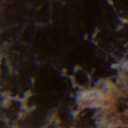

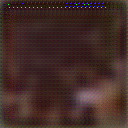

0.426356703042984
0.42528287837138545
0.4253321458708565
0.42438944511943394
0.4232922212644057
0.42189961458955494
0.4211680115314952
0.4189635206913126
0.41902739062147626
0.41819497644901277
0.41925699007315714
0.4182566164001342
0.4165914948024447
0.41530386731028557
0.4133349542434399
0.41275227702025213
0.4139584076048723
0.41449402185047374
0.4145091975080794
0.41519956631319865
0.4142752293969544
0.4161642769144641
0.41531034814168327
0.4149731925210437
0.4151233454545339
0.415169391192888
0.413595597465317
0.41315710391753757
0.41290341147893594
0.4119677387177944
0.41046143056433876
0.41067217145024276
0.410293210342706
0.4101954624056816
0.40951477254138274
0.4095847471508869
0.408871125558327
0.408337666568431
0.4084263852473055
0.4088544428348541
0.40979254016509425
0.4096004545040753
0.4087094770323846
0.4074754477181333
0.4065178996638248
0.4052340459699432
0.4052127602788591
0.40654779788182704
0.40593657620025403
0.4053384420275688


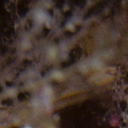

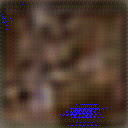

0.40411810768712864
0.4030632008524502
0.4023196381851307
0.40161786858852094
0.40108873617081414
0.4014029587214848
0.4029075247105037
0.4029021097554101
0.4040527485926217
0.4041480925950137
0.40422190094853305
0.4043800154966967
0.4034240918349376
0.403240238626798
0.4031946169293445
0.4027957410134118
0.40231362647480434
0.4016659019862191
0.40175398157424286
0.40412276387214663
0.4041657731060154
0.40379428326106465
0.4036928475872288
0.40417064389874857
0.4042966732978821
0.40363684036428965
0.40402671061162876
0.4044003349263221
0.4042928366698036
0.4052768523876484
0.40516303195298176
0.4052767487186374
0.4053463230007573
0.40475969861692457
0.4040364572295436
0.4034903568818289
0.4033449287832218
0.4033522878004157
0.4032439906820119
0.4034780836531094
0.4034865471065467
0.4027256487121045
0.40254380069412554
0.40210288638869923
0.40192673555735886
0.40137871569150113
0.4006293894482308
0.4009849348583737
0.400551953971786
0.4000883922974269


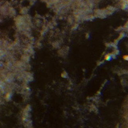

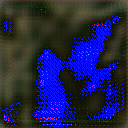

0.3993448976254621
0.39861071874436577
0.39916537965045257
0.3988372157146404
0.398382463570564
0.39847963398847824
0.39832155074283576
0.39760862592654894
0.39828088467226086
0.39840337764471767
0.3978874731508101
0.3972373562462536
0.3964368786914217
0.39685823931926634
0.39583711624145507
0.3956344508263002
0.39555178323905626
0.39553460851311684
0.3952268790563888
0.3951896593851202
0.3947159707197669
0.394849898510201
0.3946294522698904
0.39454496694707325
0.39483930519648963
0.3944354409521276
0.3936800958409821
0.3938422656795952
0.39338291057661257
0.39328593379921384
0.39403006154529296
0.39414156809612944
0.3940056241600891
0.39371593652859976
0.39364801758044476
0.39371890166113455
0.39375558702703467
0.3935600722089727
0.393376758331975
0.39301870857414445
0.39259579184791804
0.3923343570592503
0.39212379044819373
0.39173590138400954
0.39141850364513886
0.39097548337007054
0.3906025446308446
0.39007314512825975
0.3897471177817589
0.3895134057104588


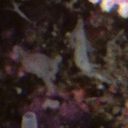

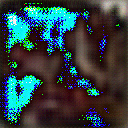

0.389248485144098
0.3885969727641285
0.3881861093302666
0.3877207924630128
0.3879464707723478
0.3880467743260189
0.3883177793544272
0.3877650651221092
0.38797016349135405
0.38764389072145733
0.38770056166355077
0.3882577734173469
0.387756777481294
0.3874445312491087
0.38709280934444695
0.3868333315131841
0.38648071267088435
0.3859415382420251
0.38584824130959705
0.38564375124194405
0.38544008796571066
0.38596341604585044
0.38539144824438565
0.38535571936517954
0.38526000261306764
0.3850506657520227
0.38449918383543713
0.38437033104791973


In [ ]:
# Pretrain the generator
# Shentong suggests 50 epochs is good for this.

nepochs = 50
pretrain_loss = l1
lr = 0.0002
G_optimizer = optim.Adam(Generator.parameters(), lr=lr)
i = 0
total_loss = []
Generator.to(cuda)
Generator.train()
for i in range(nepochs):
    Generator.train()
    for obj in train_loader:
        G_optimizer.zero_grad()
        i += 1
        lr, hr = obj
        lr = lr.to(cuda)
        hr = hr.to(cuda)

        y = Generator.forward(lr)
        loss = pretrain_loss(y, hr)
        loss.backward()
        G_optimizer.step()
        if i > 10000:
            G_scheduler.step()
        total_loss.append(loss.item())
        print(np.mean(total_loss))
    
    Generator.eval()
    x, y = full_train_data[0]
    y = undo_transform(y)
    im = transforms.ToPILImage()(y).convert("RGB")
    x = x.to(cuda)
    display(im)
    z = Generator(x.unsqueeze(0)).squeeze(0)
    z = undo_transform(z)
    im2 = transforms.ToPILImage()(z).convert("RGB")
    display(im2)


In [ ]:
torch.save({
            'epoch': 10,
            'model_state_dict': Generator.state_dict(),
            'optimizer_state_dict': Generator.state_dict(),
            'loss': loss
            }, '/content/gdrive/MyDrive/first_generator')

In [ ]:
nepochs = 200

# Shentong's comments:
# Early stopping may be important
# Idea: add PSNR metric for testing.
# Implement PSNR metric; print out the value and check it every so often

gen_l, disc_l = [], []
for i in range(nepochs):
    disc_losses = []
    gen_losses = []

    # Train the discriminator
    for obj in train_loader:
        lr, hr = obj
        Generator.to(cuda)
        Generator.eval()
        with torch.no_grad():
            lr = lr.to(cuda)
            z = Generator.forward(lr)
        z = z.to(cuda)
        Discriminator.to(cuda)
        loss = discriminator_train(hr, z, disc_loss) #disc loss is a bad name -- this is the discriminator loss
        torch.cuda.empty_cache()
        disc_losses.append(loss)

    # Train the generator
    for obj in train_loader:
        Discriminator.eval()
        lr, hr = obj
        loss = generator_train(lr, hr, gen_loss)
        torch.cuda.empty_cache()
        gen_losses.append(loss)

    x, y = full_train_data[0]
    im = transforms.ToPILImage()(y).convert("RGB")
    x = x.to(cuda)
    display(im)
    z = Generator(x.unsqueeze(0)).squeeze(0)
    z = z.to(cuda)
    im2 = transforms.ToPILImage()(z).convert("RGB")
    display(im2)

    print(disc_losses)
    print(gen_losses)

Some testing cells below:

In [ ]:
from torchvision import transforms
x, y = full_train_data[0]
im = transforms.ToPILImage()(y).convert("RGB")
display(im)

In [ ]:
x = x.to(cuda)
Generator.to(cuda)
z = Generator(x.unsqueeze(0)).squeeze(0)
im2 = transforms.ToPILImage()(z).convert("RGB")
display(im2)

In [ ]:
x, y = full_valid_data[0]
im = transforms.ToPILImage()(y).convert("RGB")
x = x.to(cuda)
display(im)
z = Generator(x.unsqueeze(0)).squeeze(0)
z = z.to(cuda)
im2 = transforms.ToPILImage()(z).convert("RGB")
display(im2)

